## Importing relevant modules and checking if GPU has been configured properly

In [1]:
import os
import glob
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

#checking GPU status
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-03-20 13:03:06.675322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 13:03:06.693518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742457786.713482  162556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742457786.718958  162556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742457786.734848  162556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


## Load and Preprocessing Anime Dataset using tensorflow

In [2]:
#resizinng all images and selecting batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 100


def preprocess_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    #normalizing between -1 and 1 
    image = (image / 127.5) - 1.0
    return image


image_files = glob.glob('./images/**/*.jpg', recursive=True)  
print(f"Found {len(image_files)} images")

#Creating a dataset loader from tf.data.Dataset from the images folder
dataset = tf.data.Dataset.from_tensor_slices(tf.constant(image_files, dtype=tf.string))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset prepared.")


Found 63565 images
Dataset prepared.


I0000 00:00:1742457790.031130  162556 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13709 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:52:00.0, compute capability: 8.6


## Defining Genertor model

In [3]:
def build_generator(latent_dim=100):
    model = tf.keras.Sequential(name="Generator")

    #reshaping to 4x4x512
    model.add(layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 512)))  # shape: 4x4x512

    #upsampling to 8x8
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #upsampling to 16x16
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #upsampling to 32x32
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #upsampling to 64x64
    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #upsampling to 128x128 and output image and usint tanh for activation
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))

    return model

latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()


/home/sacred/project/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         1,536 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,640,704 (13.89 MB)

 Trainable params: 3,623,360 (13.82 MB)

 Non-trainable params: 17,344 (67.75 KB)

## Defining Discriminator for GAN

In [4]:
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                            input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1024, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    #flattening the dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification: real or fake

    return model

discriminator = build_discriminator()
discriminator.summary()


/home/sacred/project/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/sacred/project/env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 1024)     │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,241 (42.61 MB)

 Trainable params: 11,166,401 (42.60 MB)

 Non-trainable params: 3,840 (15.00 KB)

## Loss Functions and Optimizers for GAN

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

lr = 0.0002
beta1 = 0.5


generator_optimizer = Adam(0.001, beta_1=beta1) #using higher learning rate for generator for faster adaptation
discriminator_optimizer = Adam(lr, beta_1=beta1)


## Setting Up Output Directories and Logging

In [6]:
import os
import time
import matplotlib.pyplot as plt

OUTPUT_DIR = './outputs'

#images and logs
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'generated_images')
LOGS_DIR = os.path.join(OUTPUT_DIR, 'logs')

#for model checkpoints
GENERATOR_CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints', 'generator')
DISCRIMINATOR_CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints', 'discriminator')

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(GENERATOR_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DISCRIMINATOR_CHECKPOINT_DIR, exist_ok=True)

log_file_path = os.path.join(LOGS_DIR, 'training_log.txt')

with open(log_file_path, 'w') as f:
    f.write("Epoch\tGen_Loss\tDisc_Loss\tTime(s)\n")

print(f"Directories and logs ready at {OUTPUT_DIR}")


Directories and logs ready at ./outputs


## Training Loop for GAN

In [7]:
import time

EPOCHS = 200
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, latent_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], latent_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
        
        duration = time.time() - start
        print(f"Epoch {epoch+1}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}, Time: {duration:.2f} sec")
 
        with open(log_file_path, 'a') as f:
            f.write(f"{epoch+1}\t{g_loss.numpy():.4f}\t{d_loss.numpy():.4f}\t{duration:.2f}\n")

        generate_and_save_images(generator, epoch+1, seed)
        save_generator_checkpoint(epoch+1)
        save_discriminator_checkpoint(epoch+1)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions[i]
        img = (img + 1) / 2  # Scale back to [0, 1]
        plt.imshow(img)
        plt.axis('off')
    
    plt.suptitle(f"Epoch {epoch}")
    
    save_path = os.path.join(IMAGES_DIR, f'epoch_{epoch:03d}.png')
    plt.savefig(save_path)
    print(f"Saved generated images for epoch {epoch} at {save_path}")
    
    plt.close()

def save_generator_checkpoint(epoch):
    gen_path = os.path.join(GENERATOR_CHECKPOINT_DIR, f'generator_epoch_{epoch:03d}.keras')
    generator.save(gen_path)
    print(f"Saved generator model at {gen_path}")

def save_discriminator_checkpoint(epoch):
    disc_path = os.path.join(DISCRIMINATOR_CHECKPOINT_DIR, f'discriminator_epoch_{epoch:03d}.keras')
    discriminator.save(disc_path)
    print(f"Saved discriminator model at {disc_path}")


## Training

In [8]:

train(dataset, EPOCHS)

I0000 00:00:1742457797.119426  162880 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-20 13:04:53.566225: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Gen Loss: 1.8502, Disc Loss: 0.4178, Time: 101.83 sec
Saved generated images for epoch 1 at ./outputs/generated_images/epoch_001.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_001.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_001.keras


2025-03-20 13:06:24.217573: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Gen Loss: 1.6812, Disc Loss: 0.9677, Time: 89.64 sec
Saved generated images for epoch 2 at ./outputs/generated_images/epoch_002.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_002.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_002.keras
Epoch 3, Gen Loss: 0.1383, Disc Loss: 2.4500, Time: 88.79 sec
Saved generated images for epoch 3 at ./outputs/generated_images/epoch_003.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_003.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_003.keras


2025-03-20 13:09:22.661299: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Gen Loss: 7.6967, Disc Loss: 2.2324, Time: 88.52 sec
Saved generated images for epoch 4 at ./outputs/generated_images/epoch_004.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_004.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_004.keras
Epoch 5, Gen Loss: 6.3493, Disc Loss: 0.2620, Time: 89.10 sec
Saved generated images for epoch 5 at ./outputs/generated_images/epoch_005.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_005.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_005.keras
Epoch 6, Gen Loss: 0.8826, Disc Loss: 0.8541, Time: 89.76 sec
Saved generated images for epoch 6 at ./outputs/generated_images/epoch_006.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_006.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_006.keras
Epoch 7, Gen Loss: 7.2644, Disc Loss: 0.878

2025-03-20 13:15:22.828091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Gen Loss: 2.2520, Disc Loss: 0.5369, Time: 89.02 sec
Saved generated images for epoch 8 at ./outputs/generated_images/epoch_008.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_008.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_008.keras
Epoch 9, Gen Loss: 1.1117, Disc Loss: 0.7257, Time: 89.26 sec
Saved generated images for epoch 9 at ./outputs/generated_images/epoch_009.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_009.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_009.keras
Epoch 10, Gen Loss: 1.9409, Disc Loss: 0.2240, Time: 89.88 sec
Saved generated images for epoch 10 at ./outputs/generated_images/epoch_010.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_010.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_010.keras
Epoch 11, Gen Loss: 4.9568, Disc Loss: 0.

2025-03-20 13:27:20.350025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Gen Loss: 4.5198, Disc Loss: 0.0911, Time: 88.72 sec
Saved generated images for epoch 16 at ./outputs/generated_images/epoch_016.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_016.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_016.keras
Epoch 17, Gen Loss: 3.2333, Disc Loss: 0.0730, Time: 88.76 sec
Saved generated images for epoch 17 at ./outputs/generated_images/epoch_017.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_017.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_017.keras
Epoch 18, Gen Loss: 2.7720, Disc Loss: 0.1329, Time: 86.25 sec
Saved generated images for epoch 18 at ./outputs/generated_images/epoch_018.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_018.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_018.keras
Epoch 19, Gen Loss: 7.2698, Disc Loss

2025-03-20 13:50:28.783379: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32, Gen Loss: 4.9522, Disc Loss: 0.0159, Time: 86.51 sec
Saved generated images for epoch 32 at ./outputs/generated_images/epoch_032.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_032.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_032.keras
Epoch 33, Gen Loss: 4.5090, Disc Loss: 0.0265, Time: 85.43 sec
Saved generated images for epoch 33 at ./outputs/generated_images/epoch_033.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_033.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_033.keras
Epoch 34, Gen Loss: 1.1909, Disc Loss: 0.4251, Time: 88.15 sec
Saved generated images for epoch 34 at ./outputs/generated_images/epoch_034.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_034.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_034.keras
Epoch 35, Gen Loss: 4.6117, Disc Loss

2025-03-20 14:37:52.298059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64, Gen Loss: 5.9058, Disc Loss: 0.0455, Time: 88.66 sec
Saved generated images for epoch 64 at ./outputs/generated_images/epoch_064.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_064.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_064.keras
Epoch 65, Gen Loss: 6.3850, Disc Loss: 0.0038, Time: 88.16 sec
Saved generated images for epoch 65 at ./outputs/generated_images/epoch_065.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_065.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_065.keras
Epoch 66, Gen Loss: 4.3225, Disc Loss: 0.0183, Time: 89.33 sec
Saved generated images for epoch 66 at ./outputs/generated_images/epoch_066.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_066.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_066.keras
Epoch 67, Gen Loss: 4.2109, Disc Loss

2025-03-20 16:13:18.927800: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128, Gen Loss: 6.0371, Disc Loss: 0.0065, Time: 88.73 sec
Saved generated images for epoch 128 at ./outputs/generated_images/epoch_128.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_128.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_128.keras
Epoch 129, Gen Loss: 6.4955, Disc Loss: 0.0172, Time: 87.06 sec
Saved generated images for epoch 129 at ./outputs/generated_images/epoch_129.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_129.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_129.keras
Epoch 130, Gen Loss: 11.0086, Disc Loss: 0.0950, Time: 88.60 sec
Saved generated images for epoch 130 at ./outputs/generated_images/epoch_130.png
Saved generator model at ./outputs/checkpoints/generator/generator_epoch_130.keras
Saved discriminator model at ./outputs/checkpoints/discriminator/discriminator_epoch_130.keras
Epoch 131, Gen Loss: 7.6333, D

In [2]:
import pandas as pd
import os

# Correct the log file path relative to the notebook's location
log_file_path = os.path.join('..', 'Project', 'outputs', 'logs', 'training_log.txt')

# Load the log file
logs_df = pd.read_csv(log_file_path, sep='\t')
logs_df.head()


,Epoch,Gen_Loss,Disc_Loss,Time(s)
0,1,1.8502,0.4178,101.83
1,2,1.6812,0.9677,89.64
2,3,0.1383,2.4500,88.79
3,4,7.6967,2.2324,88.52
4,5,6.3493,0.2620,89.10


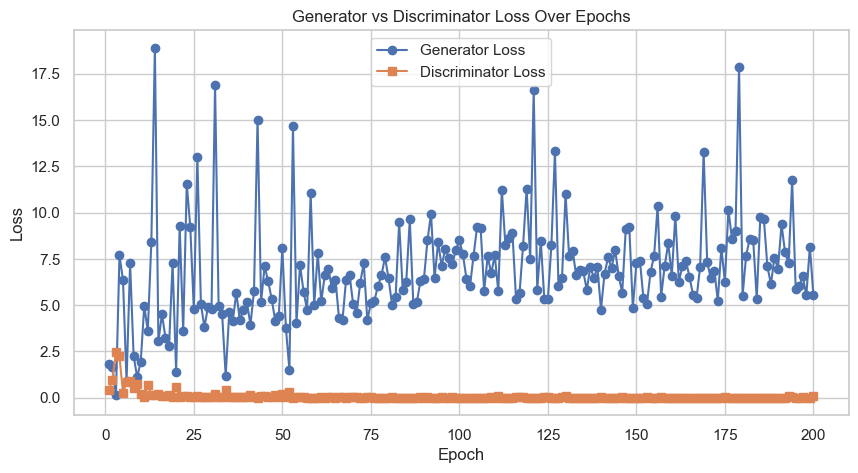

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
plt.plot(logs_df["Epoch"], logs_df["Gen_Loss"], label="Generator Loss", marker='o')
plt.plot(logs_df["Epoch"], logs_df["Disc_Loss"], label="Discriminator Loss", marker='s')

# Labels and Title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss Over Epochs")
plt.legend()
plt.show()


## Randomly generating 4 anime characters from the trained model

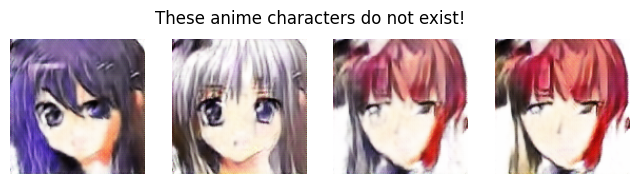

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#loading one of the epoch generator
model_path = r"C:\Project\generator\generator_epoch_131.keras"
generator = tf.keras.models.load_model(model_path)
latent_dim = generator.input_shape[1]  # Assuming it's a dense layer input

#generating random noise vectors
random_noise = np.random.normal(0, 1, (4, latent_dim)) + np.random.normal(-0.1, 0.1, (4, latent_dim))
generated_images = generator(random_noise, training=False)
generated_images = (generated_images + 1) / 2

#plotting images
fig, axes = plt.subplots(1, 4, figsize=(8, 2))

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.axis("off")

plt.suptitle("These anime characters do not exist!")
plt.show()


## **References & Acknowledgments**
This notebook is part of the **GAN Project 'This Anime does not exist'**. The implementation includes concepts from Deep Learning and Generative Adversarial Networks (GANs).  

Additionally, some portions of the code and explanations were generated with the assistance of AI-powered platforms, including **ChatGPT**, **DeepSeek**, and **Gemini**. These tools were used for debugging, optimization suggestions, and improving code efficiency.  

All generated code was reviewed and modified to ensure correctness, alignment with the assignment requirements, and compatibility with the project setup.
